# 前処理

Step0
- ファイル名と日付を整合させる処理
- citycode = 0 / NaN 除去
- time / dailyid が無い行除去

Step1
- 大カテゴリ、中カテゴリ、小カテゴリに分解
- ３次メッシュ変換

Step２
- prefcodeから東京都を抽出
- citycodeより調布市を抽出
- 調布市外は OoR（Out of Range）= 11111111 に統一
- 15分ごとのサンプリング
- 居住地付与
    - 夜間時間帯（22:00–06:00）のメッシュIDを参考にする
    - メッシュ単位で夜間の累積滞在時間を集計する
    - 累積滞在時間が最大となるメッシュを 推定居住地（home） としPoIカラムにおいてhomeを付与
    - home_stay_min ≥ 360 分 → home を採用 それ未満 → 既存の PoI（観測 PoI）をそのまま使う





Step３
遷移確率算出の処理フロー

- dailyid × time_15min で並び替え，個人ごとの時系列を構築
- 状態を (mesh_level3, poi_large) と定義する
- 個人内で t → t+15分 の次状態を shift により生成
- 15分連続でない遷移（欠測・日跨ぎ）を除外
- time_15min × 状態 × 次状態 ごとに遷移回数を集計


In [2]:
from pathlib import Path
import pandas as pd

# 検証で必要
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams


FONT_PATH = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
font_prop = font_manager.FontProperties(fname=FONT_PATH)

rcParams["font.family"] = font_prop.get_name()


pd.set_option('display.max_rows', 100)


## データを読み込む

In [3]:
# 作成するファイルの日付　指定
file_date = "20190214"

trace_path = Path("../data/raw/trace/sktrace(old)") / f"{file_date}.csv"

trace_df = pd.read_csv(trace_path,index_col=0)
trace_df = trace_df.reset_index()
trace_df = trace_df.drop(columns=['Unnamed: 0'])

display(trace_df.head())
print(f"レコード数: {len(trace_df)}")


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/trace/sktrace(old)/20190214.csv'

## Step 0
- ファイル名と日付を整合させる処理
- citycode = 0 / NaN 除去
- time / dailyid が無い行除去

In [294]:
# ファイル名と日付を整合させる処理
file_date_name = pd.to_datetime(trace_path.stem, format="%Y%m%d")
print(f"ファイルの日付: {file_date_name.date()}")

trace_df["time"] = pd.to_datetime(trace_df["time"])
trace_df["time"] = file_date_name + (trace_df["time"] - trace_df["time"].dt.normalize())

# citycode が 0 / NaN の行を除去
trace_df = trace_df.loc[
    trace_df["citycode"].notna() & (trace_df["citycode"] != 0)
].copy()

# dailyid が NaN / 空の行を除去
trace_df = trace_df.loc[
    trace_df["dailyid"].notna()
].copy()

# time が NaT の行を除去（念のため）
trace_df = trace_df.loc[
    trace_df["time"].notna()
].copy()

# インデックスを振り直す
trace_df = trace_df.reset_index(drop=True)


display(trace_df.head())


ファイルの日付: 2019-02-14


,citycode,dailyid,home_citycode,judge,lat,lon,mesh100mid,poi,prefcode,time,workplace_citycode
0,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659139,139.531276,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業', '出版・印刷', '印...",13,2019-02-14 00:00:00,13100.0
1,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業', '出版・印刷', '印...",13,2019-02-14 00:01:00,13100.0
2,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業', '出版・印刷', '印...",13,2019-02-14 00:02:00,13100.0
3,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業', '出版・印刷', '印...",13,2019-02-14 00:03:00,13100.0
4,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業', '出版・印刷', '印...",13,2019-02-14 00:04:00,13100.0


## Step1
- 大カテゴリ、中カテゴリ、小カテゴリに分解
- ３次メッシュ変換

In [295]:
# PoIカテゴリを分解
## PoIのカテゴリが2回入っているので1回にまとめる　
### 加工前の状態［大カテゴリ、中カテゴリ、小カテゴリ、大カテゴリ、中カテゴリ、小カテゴリ］

def parse_poi(x):
    # ["['A', 'B', 'C']"] の形を想定
    if isinstance(x, list):
        x = x[0]

    # 前後の [ ] を除去
    x = x.strip()
    x = x.lstrip('[').rstrip(']')

    # カンマで分割してクォート除去
    return [v.strip().strip("'").strip('"') for v in x.split(',')]


trace_df['poi'] = trace_df['poi'].apply(parse_poi)
trace_df['poi'] = trace_df['poi'].apply(lambda x: x[:3])


# poi を必ず長さ3に正規化（move / OoR 対応）
def expand_poi_to_3(x):
    if not isinstance(x, list) or len(x) == 0:
        return ["OoR", "OoR", "OoR"]
    if len(x) == 1:
        return [x[0], x[0], x[0]]
    if len(x) == 2:
        return [x[0], x[1], x[0]]
    return x[:3]


trace_df["poi"] = trace_df["poi"].apply(expand_poi_to_3)


display(trace_df[['poi']].head())

,poi
0,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]"
1,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]"
2,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]"
3,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]"
4,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]"


In [296]:
# PoIカテゴリをDataFrameに展開

trace_df[['poi_large', 'poi_middle', 'poi_small']] = pd.DataFrame(
    trace_df['poi'].tolist(),
    index=trace_df.index
)
display(trace_df.head())

# 各PoI列のユニーク数
print("largeカテゴリのユニーク数:", trace_df['poi_large'].nunique())
print("middleカテゴリのユニーク数:", trace_df['poi_middle'].nunique())
print("smallカテゴリのユニーク数:", trace_df['poi_small'].nunique())

# PoI Largeのカテゴリ一覧
large_categories = trace_df['poi_large'].unique()
print("Largeカテゴリ一覧:")
for category in large_categories:
    print("-", category)

# PoI Largeの”NA”カテゴリのデータ数
na_large_count = len(trace_df[trace_df['poi_large'] == 'NA'])
print(f"LargeカテゴリのNAのデータ数: {na_large_count}")

# NAカテゴリのデータを除去
trace_df = trace_df[trace_df['poi_large'] != 'NA']
print(f"NAカテゴリ除去後のレコード数: {len(trace_df)}")

,citycode,dailyid,home_citycode,judge,lat,lon,mesh100mid,poi,prefcode,time,workplace_citycode,poi_large,poi_middle,poi_small
0,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659139,139.531276,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:00:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業
1,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:01:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業
2,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:02:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業
3,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:03:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業
4,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:04:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業


largeカテゴリのユニーク数: 20
middleカテゴリのユニーク数: 188
smallカテゴリのユニーク数: 1034
Largeカテゴリ一覧:
- 出版・印刷
- move
- 販売・卸
- 建設・工事
- 自動車・オートバイ・自転車・ドライブ
- 交通・運輸・倉庫
- その他サービス
- 不動産・賃貸・展示場
- 学校・趣味教室・図書館
- OoR
- 医療・薬・保険衛生
- 飲食店
- 金融・保険・証券
- 官公庁・団体・福祉
- 製造・加工
- 電気・ガス・通信・放送・新聞
- スポーツ・趣味娯楽・レジャー
- 旅行・観光・温泉・旅館・ホテル
- 農林・水産・鉱業
- NA
LargeカテゴリのNAのデータ数: 150
NAカテゴリ除去後のレコード数: 9268181


In [297]:
# ３次メッシュに変換
trace_df["mesh_level3"] = trace_df["mesh100mid"].astype(str).str[:-2]

display(trace_df.head(5))

,citycode,dailyid,home_citycode,judge,lat,lon,mesh100mid,poi,prefcode,time,workplace_citycode,poi_large,poi_middle,poi_small,mesh_level3
0,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659139,139.531276,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:00:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
1,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:01:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
2,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:02:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
3,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:03:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
4,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"[出版・印刷, 印刷業, カタログ・パンフレット印刷業]",13,2019-02-14 00:04:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492


In [298]:
# step1のデータ保存
step1_path = Path(f"../data/processed/yamada_processed/traj_normalized/step1_trace_{file_date}.csv")

trace_df.to_csv(step1_path, index=False)
print(f"Step1データを保存しました: {step1_path}")

Step1データを保存しました: ../data/processed/yamada_processed/traj_normalized/step1_trace_20190214.csv


## Step２
- prefcodeから東京都を抽出 citycodeより調布市を抽出
- 調布市に出現した dailyid を取得　その dailyid を持つ「全データ」を取得
- 調布市外は OoR（Out of Range）= 11111111 に統一
- 居住地付与
    - 軌跡データに含まれる推定居住地メッシュを home 
    - 深夜帯（0–5時）の滞在履歴を集計、最長滞在メッシュを home として付与
    - 対応表の作成、数値での管理

In [299]:
# 保存したデータを確認
step1_path = Path(f"../data/processed/yamada_processed/traj_normalized/step1_trace_{file_date}.csv")
trace_df = pd.read_csv(step1_path)

display(trace_df.head(2))   


,citycode,dailyid,home_citycode,judge,lat,lon,mesh100mid,poi,prefcode,time,workplace_citycode,poi_large,poi_middle,poi_small,mesh_level3
0,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659139,139.531276,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業']",13,2019-02-14 00:00:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
1,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業']",13,2019-02-14 00:01:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492


In [300]:
# prefcodeより東京都、citycodeより調布市のデータを取得する
## JIS市区町村コード：13208（参考：東京都は 13、調布市はその中の 208）
trace_chofu_stay = trace_df[
    (trace_df["citycode"] == 13208) &
    (trace_df["judge"] == "stay")
]

# stay したユーザの dailyid
chofu_stay_dailyids = trace_chofu_stay["dailyid"].unique()

# そのユーザの全履歴を取得
trace_chofu_users = trace_df[
    trace_df["dailyid"].isin(chofu_stay_dailyids)
].copy()

display(trace_chofu_users.head())
print(f"調布市に滞在・通過したユーザのレコード数: {len(trace_chofu_users)}")

,citycode,dailyid,home_citycode,judge,lat,lon,mesh100mid,poi,prefcode,time,workplace_citycode,poi_large,poi_middle,poi_small,mesh_level3
0,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659139,139.531276,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業']",13,2019-02-14 00:00:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
1,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業']",13,2019-02-14 00:01:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
2,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業']",13,2019-02-14 00:02:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
3,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業']",13,2019-02-14 00:03:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492
4,13208.0,b840f38e37aa8356d5aca4eda196307b28287f885c7b15...,13210.0,stay,35.659066,139.531322,5339349205,"['出版・印刷', '印刷業', 'カタログ・パンフレット印刷業']",13,2019-02-14 00:04:00,13100.0,出版・印刷,印刷業,カタログ・パンフレット印刷業,53393492


調布市に滞在・通過したユーザのレコード数: 3438224


In [301]:
# trace_chofu_usersのデータの中で調布市外は mesh_level3をOoR（Out of Range）= 11111111 に統一   
CHOFU_CITY = 13208

trace_chofu_users.loc[
    trace_chofu_users["citycode"] != CHOFU_CITY,
    "mesh_level3"
] = "11111111"
trace_chofu_users["mesh_level3"].value_counts().head(10)



# 調布市のメッシュIDを持つが PoI Large が OoR のデータを除去
trace_chofu_users = trace_chofu_users.loc[
    ~(
        (trace_chofu_users["mesh_level3"] != "11111111") &
        (trace_chofu_users["poi_large"] == "OoR")
    )
].copy()

pd.set_option("display.max_rows", None)

# mesh_level3 と poi_large のクロス集計
pd.crosstab(
    trace_chofu_users["mesh_level3"],
    trace_chofu_users["poi_large"]
)


# mesh_level3 が 11111111 の行の poi_large, poi_middle, poi_small をすべて "OoR" に統一
mask_oor = trace_chofu_users["mesh_level3"] == "11111111"
trace_chofu_users.loc[mask_oor, "poi_large"] = "OoR"
trace_chofu_users.loc[mask_oor, "poi_middle"] = "OoR"
trace_chofu_users.loc[mask_oor, "poi_small"]  = "OoR"

trace_chofu_users.loc[
    trace_chofu_users["mesh_level3"] == "11111111",
    "poi_large"
].value_counts()



/var/folders/79/vl2cxy0d4h97ygg4tb8_zvdm0000gq/T/ipykernel_80713/1933127291.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11111111' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trace_chofu_users.loc[


poi_large
OoR    1711769
Name: count, dtype: int64

In [302]:
TAU_MIN = 45
NON_POI = {"move", "OoR"}

# =========================
# 1. 15分離散化
# =========================
trace_15_df = trace_chofu_users.copy()
trace_15_df["time"] = pd.to_datetime(trace_15_df["time"], errors="coerce")
trace_15_df["time_15min"] = trace_15_df["time"].dt.floor("15min")

# =========================
# 2. dailyid × time_15min の完全グリッド
# =========================
grid = (
    trace_15_df
    .groupby("dailyid")["time_15min"]
    .agg(["min", "max"])
    .reset_index()
)

grid["time_15min"] = grid.apply(
    lambda r: pd.date_range(r["min"], r["max"], freq="15min"),
    axis=1
)
grid = grid.explode("time_15min").drop(columns=["min", "max"])

# =========================
# 3. merge（欠測生成）
# =========================
trace_15_df = (
    grid
    .merge(trace_15_df, on=["dailyid", "time_15min"], how="left")
    .sort_values(["dailyid", "time_15min"])
    .reset_index(drop=True)
)

# =========================
# 4. 連続滞在補完
# =========================
# 前の PoI（階層ごと）
trace_15_df["prev_l"] = trace_15_df.groupby("dailyid")["poi_large"].ffill()
trace_15_df["prev_m"] = trace_15_df.groupby("dailyid")["poi_middle"].ffill()
trace_15_df["prev_s"] = trace_15_df.groupby("dailyid")["poi_small"].ffill()

# 次の large（判定用）
trace_15_df["next_l"] = trace_15_df.groupby("dailyid")["poi_large"].bfill()

# 時刻差（分）
trace_15_df["gap_prev"] = (
    trace_15_df.groupby("dailyid")["time_15min"]
    .diff().dt.total_seconds().div(60)
)
trace_15_df["gap_next"] = (
    trace_15_df.groupby("dailyid")["time_15min"]
    .diff(-1).abs().dt.total_seconds().div(60)
)

# 補完条件
mask_fill = (
    trace_15_df["poi_large"].isna()
    & (trace_15_df["prev_l"] == trace_15_df["next_l"])
    & (~trace_15_df["prev_l"].isin(NON_POI))
    & (trace_15_df["gap_prev"] <= TAU_MIN)
    & (trace_15_df["gap_next"] <= TAU_MIN)
)

# ★ 正しい補完（3階層同時）
trace_15_df.loc[mask_fill, "poi_large"]  = trace_15_df.loc[mask_fill, "prev_l"]
trace_15_df.loc[mask_fill, "poi_middle"] = trace_15_df.loc[mask_fill, "prev_m"]
trace_15_df.loc[mask_fill, "poi_small"]  = trace_15_df.loc[mask_fill, "prev_s"]

# =========================
# 5. 未補完は move
# =========================
mask_na = trace_15_df["poi_large"].isna()
trace_15_df.loc[mask_na, ["poi_large", "poi_middle", "poi_small"]] = "move"

# 正規化（必須）
mask_move = trace_15_df["poi_large"] == "move"
trace_15_df.loc[mask_move, ["poi_middle", "poi_small"]] = "move"

mask_oor = trace_15_df["poi_large"] == "OoR"
trace_15_df.loc[mask_oor, ["poi_middle", "poi_small"]] = "OoR"

# =========================
# 6. 一時カラム削除
# =========================
trace_15_df = trace_15_df.drop(
    columns=["prev_l", "prev_m", "prev_s", "next_l", "gap_prev", "gap_next"],
    errors="ignore"
)

display(trace_15_df.head(5))
print(f"サンプリング後のレコード数: {len(trace_15_df)}")


,dailyid,time_15min,citycode,home_citycode,judge,lat,lon,mesh100mid,poi,prefcode,time,workplace_citycode,poi_large,poi_middle,poi_small,mesh_level3
0,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14,13208.0,13210.0,stay,35.659650,139.582637,5339349616,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:06:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496
1,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14,13208.0,13210.0,stay,35.659626,139.582480,5339349615,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:07:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496
2,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14,13208.0,13210.0,stay,35.659626,139.582480,5339349615,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:08:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496
3,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14,13208.0,13210.0,stay,35.659626,139.582480,5339349615,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:09:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496
4,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14,13208.0,13210.0,stay,35.659626,139.582480,5339349615,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:10:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496


サンプリング後のレコード数: 3437756


### 居住地付与
- 各スロットでの重複を削除　15分単位の行において一行にする
- 夜間時間帯（22:00–06:00）のメッシュIDを参考にする
- メッシュ単位で夜間の累積滞在時間を集計する
- 累積滞在時間が最大となるメッシュを 推定居住地（home） としPoIカラムにおいてhomeを付与
- home_stay_min ≥ 360 分 → home を採用 それ未満 → 既存の PoI（観測 PoI）をそのまま使う


In [303]:
# 正規化関数定義
def normalize_to_slot_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    dailyid × time_15min を 1行に正規化する
    """
    slot_df = (
        df
        .sort_values(["dailyid", "time_15min"])
        .drop_duplicates(
            ["dailyid", "time_15min"],
            keep="first"   # or last / rule-based
        )
        .reset_index(drop=True)
    )
    return slot_df

slot_df = normalize_to_slot_df(trace_15_df)
display(slot_df.head(5))

# 検証
slot_df.groupby(["dailyid", "time_15min"]).size().max()


,dailyid,time_15min,citycode,home_citycode,judge,lat,lon,mesh100mid,poi,prefcode,time,workplace_citycode,poi_large,poi_middle,poi_small,mesh_level3
0,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14 00:00:00,13208.0,13210.0,stay,35.659650,139.582637,5339349616,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:06:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496
1,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14 00:15:00,13208.0,13210.0,stay,35.659626,139.582480,5339349615,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:15:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496
2,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14 00:30:00,13208.0,13210.0,stay,35.659652,139.582543,5339349616,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:30:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496
3,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14 00:45:00,13208.0,13210.0,stay,35.659623,139.582670,5339349616,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:45:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496
4,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14 01:00:00,13208.0,13210.0,stay,35.659652,139.582618,5339349616,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 01:00:00,13210.0,医療・薬・保険衛生,医療機関,内科,53393496


np.int64(1)

In [304]:
def assign_home_poi_on_slot_df(
    trace_15_df: pd.DataFrame,
    stay_min: int = 15,
    night_start: int = 22,
    night_end: int = 6,
    home_threshold_min: int = 360,  # ★ 追加
) -> pd.DataFrame:
    """
    slot_df（dailyid × time_15min = 1行）を作成し，
    夜間累積滞在時間が閾値以上のときのみ home を付与する．
    閾値未満の場合は既存 PoI を保持する．
    """

    # =========================
    # 0. slot 正規化
    # =========================
    slot_df = (
        trace_15_df
        .sort_values(["dailyid", "time_15min"])
        .drop_duplicates(["dailyid", "time_15min"])
        .copy()
    )

    # =========================
    # 1. 夜間抽出（slot 単位）
    # =========================
    night_df = slot_df.loc[
        (slot_df["time_15min"].dt.hour >= night_start)
        | (slot_df["time_15min"].dt.hour < night_end),
        ["dailyid", "time_15min", "mesh_level3"]
    ].dropna(subset=["mesh_level3"])

    # =========================
    # 2. 夜間滞在時間（dailyid × mesh）
    # =========================
    night_stay = (
        night_df
        .groupby(["dailyid", "mesh_level3"], as_index=False)
        .size()
        .rename(columns={"size": "n_slot"})
    )
    night_stay["stay_min"] = night_stay["n_slot"] * stay_min

    # =========================
    # 3. home 候補 + 滞在時間
    # =========================
    home_candidate_df = (
        night_stay
        .sort_values(["dailyid", "stay_min"], ascending=[True, False])
        .drop_duplicates("dailyid")
        .rename(columns={"mesh_level3": "home_mesh"})
        [["dailyid", "home_mesh", "stay_min"]]
    )

    # =========================
    # 4. 閾値判定（home を使うかどうか）
    # =========================
    home_candidate_df["use_home"] = (
        home_candidate_df["stay_min"] >= home_threshold_min
    )

    # =========================
    # 5. slot_df に merge
    # =========================
    slot_df = slot_df.merge(
        home_candidate_df[["dailyid", "home_mesh", "use_home"]],
        on="dailyid",
        how="left"
    )

    # =========================
    # 6. home を使う人だけ PoI を上書き
    # =========================
    mask_home = (
        (slot_df["use_home"]) &
        (slot_df["mesh_level3"] == slot_df["home_mesh"])
    )

    slot_df.loc[mask_home, ["poi_large", "poi_middle", "poi_small"]] = "home"

    # =========================
    # 7. 後片付け
    # =========================
    return slot_df.drop(columns=["home_mesh", "use_home"], errors="ignore")

slot_df = assign_home_poi_on_slot_df(trace_15_df)

slot_df.groupby(["dailyid", "time_15min"]).size().max()
# => 1
slot_df["poi_large"].value_counts(dropna=False)


poi_large
home                  92354
OoR                   83370
move                  22874
その他サービス                4335
販売・卸                   3654
飲食店                    3360
自動車・オートバイ・自転車・ドライブ     3131
医療・薬・保険衛生              3130
建設・工事                  2953
官公庁・団体・福祉              2876
学校・趣味教室・図書館            2807
製造・加工                  2147
スポーツ・趣味娯楽・レジャー         1650
不動産・賃貸・展示場              918
交通・運輸・倉庫                854
金融・保険・証券                780
電気・ガス・通信・放送・新聞          294
出版・印刷                   147
旅行・観光・温泉・旅館・ホテル         127
農林・水産・鉱業                  2
Name: count, dtype: int64

#### 検証コード

count    1480.000000
mean      448.368243
std        43.193077
min       360.000000
25%       420.000000
50%       480.000000
75%       480.000000
max       480.000000
Name: home_stay_min, dtype: float64


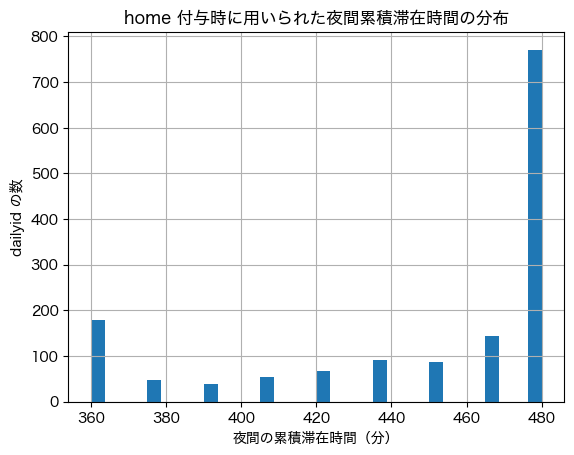

In [305]:
##  home付与における累積滞在時間の分布

STAY_MIN = 15
NIGHT_START = 22
NIGHT_END = 6

# =========================
# 1. home_mesh を dailyid ごとに特定
# =========================
home_mesh_df = (
    slot_df.loc[slot_df["poi_large"] == "home", ["dailyid", "mesh_level3"]]
    .dropna()
    .drop_duplicates()
    .groupby("dailyid", as_index=False)
    .agg(home_mesh=("mesh_level3", "first"))
)

# sanity check（1人1homeか）
assert (
    slot_df.loc[slot_df["poi_large"] == "home"]
    .groupby("dailyid")["mesh_level3"]
    .nunique()
    .max()
    <= 1
), "dailyid に複数 home_mesh が存在します"

# =========================
# 2. 夜間 slot を抽出
# =========================
night_slot = slot_df.loc[
    (slot_df["time_15min"].dt.hour >= NIGHT_START)
    | (slot_df["time_15min"].dt.hour < NIGHT_END),
    ["dailyid", "time_15min", "mesh_level3"]
].dropna(subset=["mesh_level3"])

# =========================
# 3. home_mesh を付与
# =========================
night_slot = night_slot.merge(home_mesh_df, on="dailyid", how="left")

# =========================
# 4. home に滞在していた夜間スロット数を集計
# =========================
home_night_stay = (
    night_slot.loc[night_slot["mesh_level3"] == night_slot["home_mesh"]]
    .groupby("dailyid", as_index=False)
    .agg(n_slot=("time_15min", "count"))
)

home_night_stay["home_stay_min"] = home_night_stay["n_slot"] * STAY_MIN

# =========================
# 5. 分布を見る（数値）
# =========================
print(home_night_stay["home_stay_min"].describe())

# =========================
# 6. 分布を見る（ヒストグラム）
# =========================
plt.figure()
home_night_stay["home_stay_min"].hist(bins=32)
plt.xlabel("夜間の累積滞在時間（分）")
plt.ylabel("dailyid の数")
plt.title("home 付与時に用いられた夜間累積滞在時間の分布")
plt.show()

In [306]:
# step2のデータ保存
step2_path = Path(f"../data/processed/yamada_processed/traj_scoped/step2_trace_{file_date}.csv")
slot_df.to_csv(step2_path, index=False)
print(f"Step2データを保存しました: {step2_path}")

Step2データを保存しました: ../data/processed/yamada_processed/traj_scoped/step2_trace_20190214.csv


## Step３

遷移確率算出の処理フロー（trace_15_df → 遷移確率）

- dailyid × time_15min で並び替え，個人ごとの時系列を構築
- 状態を (mesh_level3, poi_large) と定義する
- 個人内で t → t+15分 の次状態を shift により生成
- 15分連続でない遷移（欠測・日跨ぎ）を除外
- time_15min × 状態 × 次状態 ごとに遷移回数を集計

In [307]:
# 保存したデータを確認
step2_path = Path(f"../data/processed/yamada_processed/traj_scoped/step2_trace_{file_date}.csv")
trace_15_df = pd.read_csv(step2_path)

display(trace_15_df.head(2))   


,dailyid,time_15min,citycode,home_citycode,judge,lat,lon,mesh100mid,poi,prefcode,time,workplace_citycode,poi_large,poi_middle,poi_small,mesh_level3
0,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14 00:00:00,13208.0,13210.0,stay,35.659650,139.582637,5339349616,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:06:00,13210.0,home,home,home,53393496
1,000dff9c3ba2ad636ce020d8f83ca487ea0c47641e131a...,2019-02-14 00:15:00,13208.0,13210.0,stay,35.659626,139.582480,5339349615,"['医療・薬・保険衛生', '医療機関', '内科']",13,2019-02-14 00:15:00,13210.0,home,home,home,53393496


In [308]:
# =========================
# Step 0: 前処理
# =========================
df = (
    trace_15_df
    .sort_values(["dailyid", "time_15min"])
    .copy()
)

df["time_15min"] = pd.to_datetime(df["time_15min"], errors="coerce")

# =========================
# Step 1: 状態定義
# =========================
df["state_mesh"] = df["mesh_level3"]
df["state_poi"]  = df["poi_large"]

# =========================
# Step 2: 次状態生成（個人内）
# =========================
df["next_mesh"] = df.groupby("dailyid")["state_mesh"].shift(-1)
df["next_poi"]  = df.groupby("dailyid")["state_poi"].shift(-1)
df["next_time"] = df.groupby("dailyid")["time_15min"].shift(-1)


# =========================
# Step 3: 遷移人数集計（★保存対象・十分統計量）
# =========================
transition_count_df = (
    df
    .loc[df["next_time"].notna()]  # 最終時刻だけ除外
    .groupby(
        [
            "time_15min",
            "state_mesh",
            "state_poi",
            "next_mesh",
            "next_poi",
        ],
        as_index=False
    )
    .agg(n_transition=("dailyid", "count"))
)



In [309]:
pd.set_option("display.max_rows", 5)
display(transition_count_df)

,time_15min,state_mesh,state_poi,next_mesh,next_poi,n_transition
0,2019-02-14 00:00:00,11111111,OoR,11111111.0,OoR,34
1,2019-02-14 00:00:00,11111111,OoR,53393474.0,home,1
...,...,...,...,...,...,...
28378,2019-02-14 23:30:00,53394414,建設・工事,53394414.0,建設・工事,1
28379,2019-02-14 23:30:00,53394415,home,53394415.0,home,1


In [ ]:
# =========================
# シミュレーション用データ構造作成
    # 正解滞在分布　メッシュ・PoIごと時間帯別エージェント人数分布
# =========================

out_path = Path(
    f"../data/processed/yamada_processed/trans_count/state_count_{file_date}.csv"
)


transition_count_df.to_csv(out_path,index=False)
print(f"状態人数分布データを保存しました: {out_path}")


状態人数分布データを保存しました: ../data/processed/yamada_processed/trans_count/state_count_20190214.parquet
